In [10]:
using FastAI, StaticArrays, Colors
using FastAI: FluxTraining
import CairoMakie

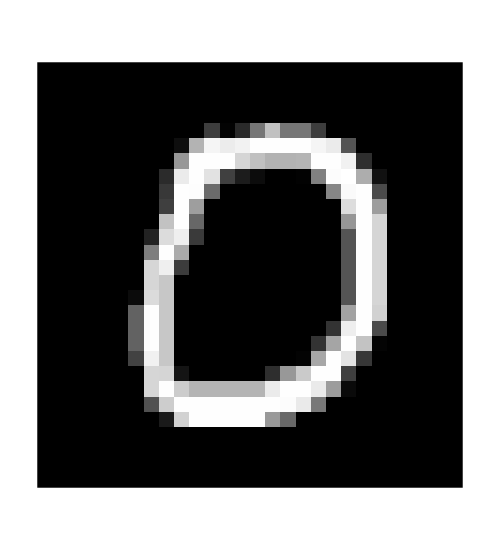

In [12]:
path = datasetpath("mnist_png")
data = Datasets.loadfolderdata(
    path,
    filterfn = isimagefile,
    loadfn = loadfile,
)
showblock(Image{2}(), getobs(data, 1))

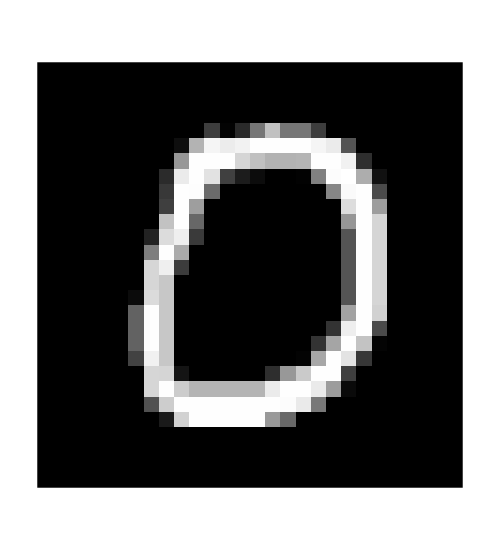

In [14]:

using FastAI: AbstractBlockMethod, encodedblockfilled, decodedblockfilled
struct EmbeddingMethod{B<:NamedTuple,E} <: AbstractBlockMethod
    blocks::B
    encodings::E
end

function EmbeddingMethod(block, encodings)
    sample = input = target = block
    encodedsample = x = y = ŷ = encodedblockfilled(encodings, sample)
    pred = decodedblockfilled(encodings, ŷ)
    blocks = (; sample, x, y, ŷ, encodedsample, pred, input, target)
    EmbeddingMethod(blocks, encodings)
end


Base.show(io::IO, task::EmbeddingMethod) =
    print(io, "EmbeddingMethod($(summary(task.blocks.sample)))")


method = EmbeddingMethod(
    Image{2}(),
    (ImagePreprocessing(means = SVector(0.0), stds = SVector(1.0), C = Gray{Float32}),),
)

x = encode(method, Training(), getobs(data, 1))
showencodedsample(method, x)

In [32]:

struct VAE{E, D}
    encoder::E
    decoder::D
end

Flux.@functor VAE

function (vae::VAE)(xs)
    μ, logσ² = learner.model.encoder(xs)
    zs = sample_latent(μ, logσ²)
    x̄s = learner.model.decoder(zs)
    return x̄s, (; μ, logσ²)
end


using Random: randn!
using Statistics: mean

sample_latent(μ::AbstractArray{T}, logσ²::AbstractArray{T}) where {T} =
    μ .+ exp.(logσ² ./ 2) .* randn!(similar(logσ²))

function βELBO(x, x̄, μ, logσ²; β = 1)
    reconstruction_error = mean(sum(@.((x̄ - x)^2); dims = 1))
    # D(N(μ, Σ)||N(0, I)) = 1/2 * (μᵀμ + tr(Σ) - length(μ) - log(|Σ|))
    kl_divergence = mean(sum(@.((μ^2 + exp(logσ²) - 1 - logσ²) / 2); dims = 1))

    return reconstruction_error + β * kl_divergence
end

βELBO (generic function with 1 method)

In [20]:

SIZE = (28, 28, 1)
Din = prod(SIZE)
Dhidden = 512
Dlatent = 2

encoder =
    Chain(
        flatten,
        Dense(Din, Dhidden, relu), # backbone
        Parallel(
            tuple,
            Dense(Dhidden, Dlatent), # μ
            Dense(Dhidden, Dlatent),  # logσ²
        ),
    ) |> gpu

decoder = Chain(Dense(Dlatent, Dhidden, relu), Dense(Dhidden, Din, sigmoid), xs -> reshape(xs, SIZE..., :)) |> gpu

model = VAE(encoder, decoder);

In [25]:
traindl, validdl =
    methoddataloaders(data, data, method, 1024, buffered = false)
traindl = collect(traindl);

In [36]:

struct VAETrainingPhase <: FluxTraining.AbstractTrainingPhase end

function FluxTraining.step!(learner, phase::VAETrainingPhase, batch)
    FluxTraining.runstep(learner, phase, (x = batch,)) do handle, state
        x = state.x
        gs = gradient(learner.params) do
            # get encode, sample latent space, decode
            x̄, (; μ, logσ²) = learner.model(x)
            handle(FluxTraining.LossBegin())
            state.loss = learner.lossfn(flatten(x), flatten(x̄), μ, logσ²)

            handle(FluxTraining.BackwardBegin())
            return state.loss
        end
        handle(FluxTraining.BackwardEnd())
        Flux.Optimise.update!(learner.optimizer, learner.params, gs)
    end
end

# for ToGPU to work
function FluxTraining.on(
    ::FluxTraining.StepBegin,
    ::VAETrainingPhase,
    cb::ToDevice,
    learner,
)
    learner.step.x = cb.movedatafn(learner.step.x)
end

In [38]:
opt = ADAM(1e-3)
learner = Learner(model, (training = traindl,), opt, βELBO, ToGPU())
FluxTraining.removecallback!(learner, ProgressPrinter)

ProgressPrinter()

In [39]:
fitonecycle!(
    learner,
    30,
    0.01,
    dataiters = (learner.data.training,),
    phases = (VAETrainingPhase(),),
)

┌──────────────────┬───────┬─────────┐
│            Phase │ Epoch │    Loss │
├──────────────────┼───────┼─────────┤
│ VAETrainingPhase │   1.0 │ 100.814 │
└──────────────────┴───────┴─────────┘
┌──────────────────┬───────┬─────────┐
│            Phase │ Epoch │    Loss │
├──────────────────┼───────┼─────────┤
│ VAETrainingPhase │   2.0 │ 54.5541 │
└──────────────────┴───────┴─────────┘
┌──────────────────┬───────┬─────────┐
│            Phase │ Epoch │    Loss │
├──────────────────┼───────┼─────────┤
│ VAETrainingPhase │   3.0 │ 49.6636 │
└──────────────────┴───────┴─────────┘
┌──────────────────┬───────┬────────┐
│            Phase │ Epoch │   Loss │
├──────────────────┼───────┼────────┤
│ VAETrainingPhase │   4.0 │ 45.739 │
└──────────────────┴───────┴────────┘
┌──────────────────┬───────┬─────────┐
│            Phase │ Epoch │    Loss │
├──────────────────┼───────┼─────────┤
│ VAETrainingPhase │   5.0 │ 43.4472 │
└──────────────────┴───────┴─────────┘
┌──────────────────┬───────┬──

┌──────────────────┬───────┬─────────┐
│            Phase │ Epoch │    Loss │
├──────────────────┼───────┼─────────┤
│ VAETrainingPhase │  24.0 │ 37.2937 │
└──────────────────┴───────┴─────────┘
┌──────────────────┬───────┬─────────┐
│            Phase │ Epoch │    Loss │
├──────────────────┼───────┼─────────┤
│ VAETrainingPhase │  25.0 │ 37.2094 │
└──────────────────┴───────┴─────────┘
┌──────────────────┬───────┬────────┐
│            Phase │ Epoch │   Loss │
├──────────────────┼───────┼────────┤
│ VAETrainingPhase │  26.0 │ 37.139 │
└──────────────────┴───────┴────────┘
┌──────────────────┬───────┬─────────┐
│            Phase │ Epoch │    Loss │
├──────────────────┼───────┼─────────┤
│ VAETrainingPhase │  27.0 │ 37.0836 │
└──────────────────┴───────┴─────────┘
┌──────────────────┬───────┬─────────┐
│            Phase │ Epoch │    Loss │
├──────────────────┼───────┼─────────┤
│ VAETrainingPhase │  28.0 │ 37.0444 │
└──────────────────┴───────┴─────────┘
┌──────────────────┬───────┬──

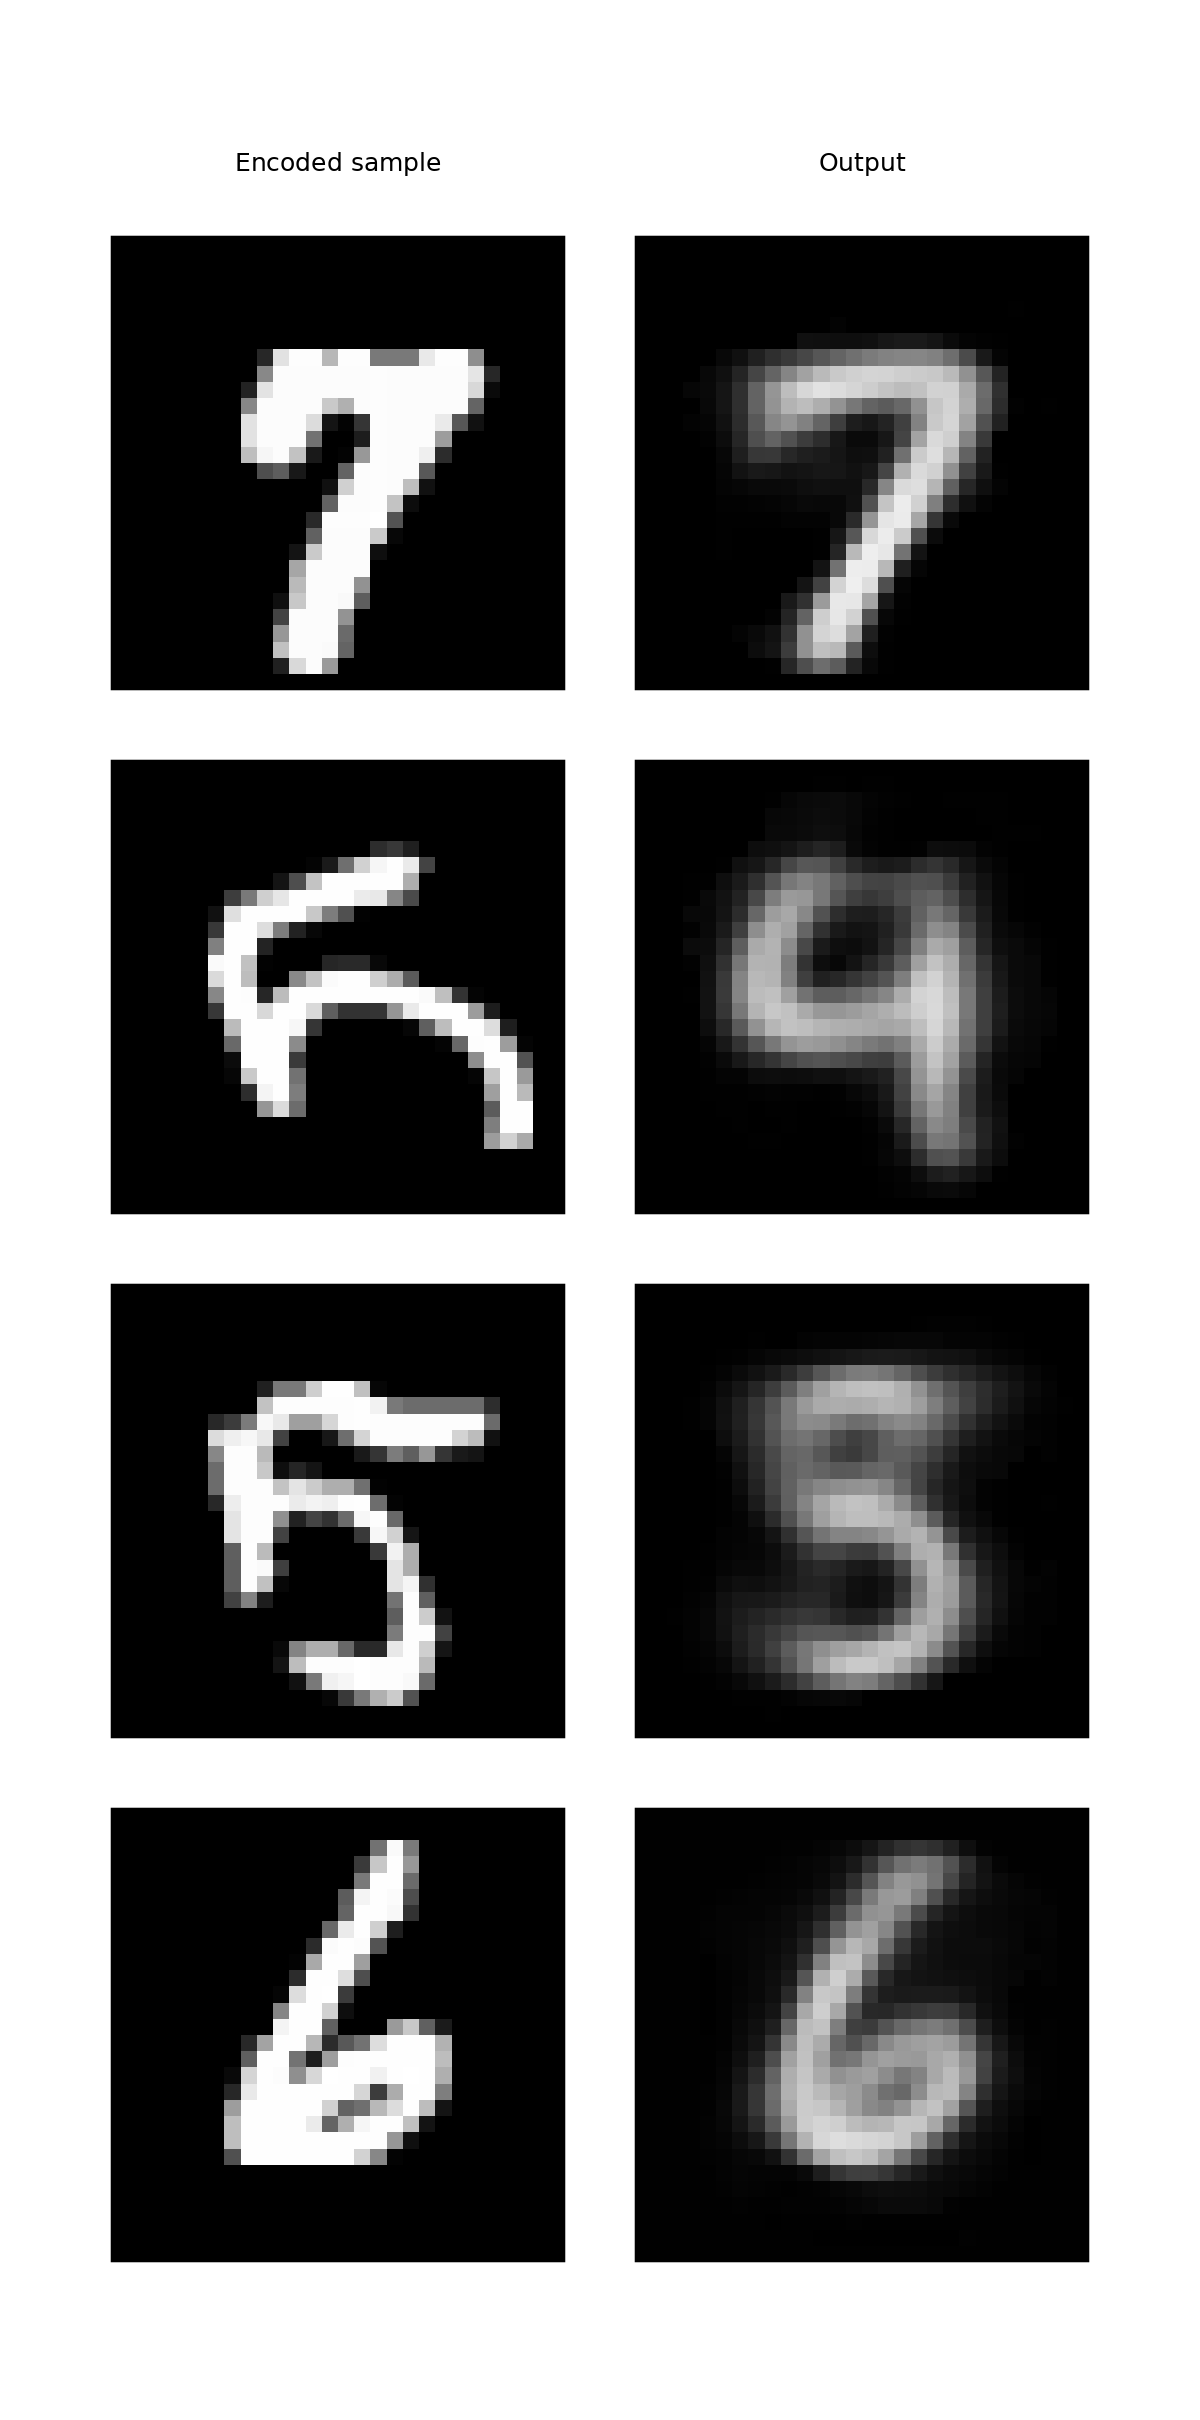

In [43]:
xs = makebatch(method, data, rand(1:nobs(data), 4)) |> gpu
ypreds, _ = model(xs) |> cpu
showoutputbatch(method, cpu(xs), ypreds)